In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Entrenamiento de Autoencoder Convolucional (CAE)



En este notebook se entrenan varios modelos Autoencoer Convolucionales sobre el conjunto de _patches_ obtenidos en el paso anterior. Primero se ajustarán CAEs con el objetivo de extraer un conjunto reducido de variables latentes que definan las imágenes, los resultados de esto son analizados en mayor profundidad en el siguiente notebook. El segundo objetivo es entrenar dos CAEs, uno con _slides_ tumorales y otro con normales y evaluar los errores de reconstrucción sobre cada uno de los conjuntos.

Para entender mejor sobre el uso del CAE y la metodolgía que se sigue en este _notebook_ se recomienda leer previamente los ejemplos con el dataset de MNIST, disponibles en los notebooks *CAE_example_mnist_1.ipynb* y *CAE_example_mnist_2.ipynb*.

**Librerias**

In [6]:
import yaml
import os
import re
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [7]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs
from utils import read_images

**Configuración**

In [41]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

In [9]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')
models_path = os.path.join(conf['data_path'], 'models')
image_size = conf['wsi']['patch_size']

**Lectura de DataFrames**

In [10]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')

In [11]:
slide_to_patch_columns = ['case_id', 'sample_id', 'slide_id', 'disease_type', 'sample_type', 
                          'percent_normal_cells', 'percent_stromal_cells', 'percent_tumor_cells', 'percent_tumor_nuclei']

## División en conjunto de Train y Test

El primer paso para entrenar un modelo es la división de los datos en los conjuntos de _train_ y _test_, de esta manera siempre se guarda una parte de los datos que el modelo 'no habrá visto' para evaluar su rendimiento. En este caso, esta división no se va a hacer aleatoria sobre el conjunto de *patches* si no que se hará la **división sobre el conjunto de slides**. El motivo es que dos *patches* de una misma imagen pueden ser muy similares al estar uno al lado de otro y por tanto la evaluación sería engañosa.

Además, puesto que se analizarán las variables latentes generadas con respecto al cáncer es conveniente manetener el ratio de imágenes tumorales y sanas en los conjuntos de train y test, para ello se hace la divisón estratificada por esa columna.

In [14]:
slides_df = slides_df[slides_df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

In [23]:
slides_df['sample_type'].value_counts(normalize=True)

Primary Tumor          0.855469
Solid Tissue Normal    0.144531
Name: sample_type, dtype: float64

In [24]:
slides_train, slides_test = train_test_split(slides_df, test_size=0.2, 
                                             stratify=slides_df['sample_type'], random_state=conf['seed']) 

In [25]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.857843
Solid Tissue Normal    0.142157
Name: sample_type, dtype: float64

In [26]:
slides_test['sample_type'].value_counts(normalize=True)

Primary Tumor          0.846154
Solid Tissue Normal    0.153846
Name: sample_type, dtype: float64

## DataFrames de patches

A continuación se crean los DataFrames de train y test a nivel _patch_. Se lee el directorio de imágenes y, a partir del nombre, se extrae el ID de la slide al que corresponde.

__Obtención de los DataFrames__

In [27]:
regex_slide_id = re.compile('.*(TCGA.*)_\d+_\d+\.png')

In [28]:
patches_df = []

for file_name in os.listdir(patches_path):
    
    if not file_name.endswith('.png'):
        continue
    
    slide_id = regex_slide_id.match(file_name).groups()[0]
    patches_df.append({'slide_id': slide_id, 'filename': file_name})
    
patches_df = pd.DataFrame(patches_df)

In [29]:
patches_df.head(5)

filename                 slide_id
0   TCGA-HZ-7926-01A-01-TS1_32_49.png  TCGA-HZ-7926-01A-01-TS1
1  TCGA-IB-A5SQ-01A-01-TSA_28_135.png  TCGA-IB-A5SQ-01A-01-TSA
2   TCGA-HZ-7925-01A-01-TS1_30_69.png  TCGA-HZ-7925-01A-01-TS1
3   TCGA-IB-7645-01A-01-BS1_92_17.png  TCGA-IB-7645-01A-01-BS1
4   TCGA-IB-7651-01A-01-BS1_29_58.png  TCGA-IB-7651-01A-01-BS1

Se añaden los metadatos a de cada slide a sus _patches_.

In [31]:
training_patches_df = patches_df.merge(slides_train[slide_to_patch_columns], on='slide_id').sample(frac=1, random_state=conf['seed'])
test_patches_df = patches_df.merge(slides_test[slide_to_patch_columns], on='slide_id').sample(frac=1, random_state=conf['seed'])

Divisón de train y test en conjuntos sanos y tumorales. Será necesario en el último apartado cuando se entrenen modelos independedientes. Aquí es importante recordar que, aunque un *patch* esté marcado como tumoral esto quiere decir que pertenece a una *slide* que tumoral. Como el tumor estará localizado en una zona concreta del tejido y no en toda la *slide*, un *patch* marcado como tumoral puede se realmente un tejido sano.

In [32]:
training_patches_tumor_df = training_patches_df[training_patches_df['sample_type'] == 'Primary Tumor']
training_patches_normal_df = training_patches_df[training_patches_df['sample_type'] == 'Solid Tissue Normal']

test_patches_tumor_df = test_patches_df[test_patches_df['sample_type'] == 'Primary Tumor']
test_patches_normal_df = test_patches_df[test_patches_df['sample_type'] == 'Solid Tissue Normal']

In [33]:
training_patches_tumor_df.head(3)

filename                 slide_id  \
42920  TCGA-IB-7654-01A-01-BS1_05_21.png  TCGA-IB-7654-01A-01-BS1   
53929  TCGA-IB-7891-01A-01-TS1_22_12.png  TCGA-IB-7891-01A-01-TS1   
10924  TCGA-FB-AAPS-01A-01-TS1_43_13.png  TCGA-FB-AAPS-01A-01-TS1   

            case_id         sample_id                  disease_type  \
42920  TCGA-IB-7654  TCGA-IB-7654-01A  Ductal and Lobular Neoplasms   
53929  TCGA-IB-7891  TCGA-IB-7891-01A  Ductal and Lobular Neoplasms   
10924  TCGA-FB-AAPS  TCGA-FB-AAPS-01A  Ductal and Lobular Neoplasms   

         sample_type  percent_normal_cells  percent_stromal_cells  \
42920  Primary Tumor                  15.0                   11.0   
53929  Primary Tumor                  10.0                   15.0   
10924  Primary Tumor                   0.0                   30.0   

       percent_tumor_cells  percent_tumor_nuclei  
42920                 74.0                  61.0  
53929                 75.0                  70.0  
10924                 70.0                  70.0

In [34]:
training_patches_normal_df.head(3)

filename                 slide_id  \
33647  TCGA-PZ-A5RE-11A-01-TS1_044_118.png  TCGA-PZ-A5RE-11A-01-TS1   
18624  TCGA-FZ-5919-11A-01-TS1_080_098.png  TCGA-FZ-5919-11A-01-TS1   
11616  TCGA-FZ-5920-11A-01-TS1_053_072.png  TCGA-FZ-5920-11A-01-TS1   

            case_id         sample_id                  disease_type  \
33647  TCGA-PZ-A5RE  TCGA-PZ-A5RE-11A  Ductal and Lobular Neoplasms   
18624  TCGA-FZ-5919  TCGA-FZ-5919-11A  Ductal and Lobular Neoplasms   
11616  TCGA-FZ-5920  TCGA-FZ-5920-11A  Ductal and Lobular Neoplasms   

               sample_type  percent_normal_cells  percent_stromal_cells  \
33647  Solid Tissue Normal                 100.0                    0.0   
18624  Solid Tissue Normal                   NaN                    NaN   
11616  Solid Tissue Normal                   NaN                    NaN   

       percent_tumor_cells  percent_tumor_nuclei  
33647                  0.0                   0.0  
18624                  NaN                   NaN  
11616                  NaN                   NaN

**Muestras de imágenes**

Tejido Tumoral

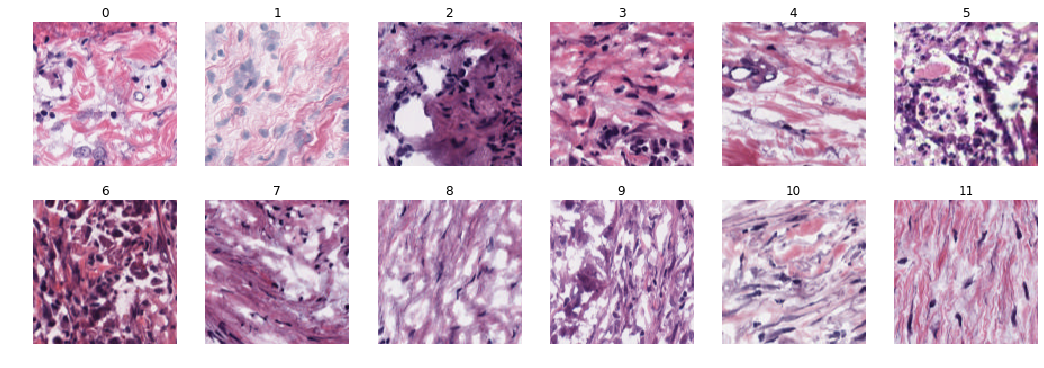

In [35]:
images_tumor_sample = read_images(training_patches_tumor_df['filename'].iloc[:20], patches_path)
plot_sample_imgs(images_tumor_sample, n_rows=2, n_cols=6, shuffle=False)

Tejido Sano

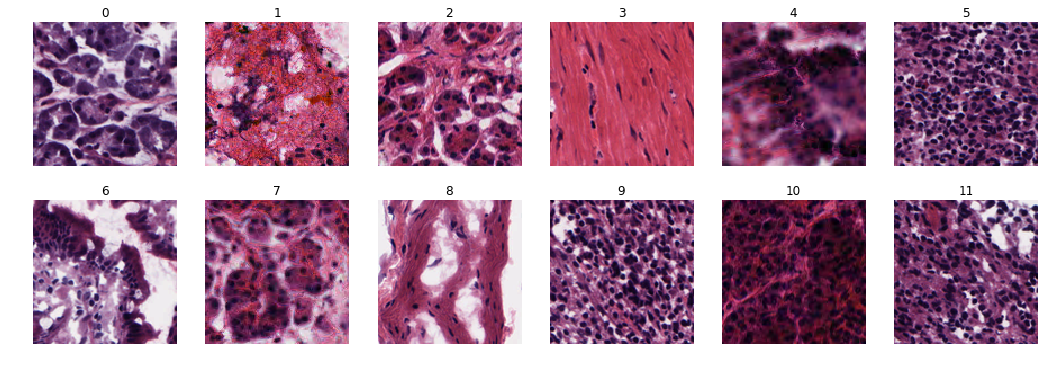

In [36]:
images_normal_sample = read_images(training_patches_normal_df['filename'].iloc[:20], patches_path)
plot_sample_imgs(images_normal_sample, n_rows=2, n_cols=6, shuffle=False)

__Guardado__

Se guardan los dataframes en ficheros CSV por si fuera necesario reutilizarlos y que no haga falta ejecutar todo el proceso anterior.

In [51]:
training_patches_df.to_csv(os.path.join(conf['data_path'], 'train.csv'), sep='|', index=False)
test_patches_df.to_csv(os.path.join(conf['data_path'], 'test.csv'), sep='|', index=False)

## Lectores de Imágenes

En total se tienen aproximadamente 75mil imagenes de 128x128 píxeles, esto equivale a 2.5GB en memoria. Para evitar cargar todas las imágenes a la vez se utlizará la herramienta de _ImageDataGenerator_. 

**Importante:** hay que reescalar las imágenes entre 0 y 1 ya que por defecto cada píxel toma el nivel de escala de 8 bits, es decir, un valor entero entre 0 y 255.

In [37]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                    target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                    subset='training', seed=conf['seed'])

validation_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                         target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                         subset='validation', seed=conf['seed'])

Found 47949 images.
Found 11987 images.


In [38]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(test_patches_df, directory=patches_path, x_col='filename', 
                                                  target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                  seed=conf['seed'])

Found 14521 images.


## Entramiento del modelo

### Entrenamiento único

La arquitectura del modelo está definida en el fichero de configuración.

In [43]:
conf['model']['cae']

{'filters': [8, 16, 32], 'latent_features': 512}

In [47]:
cae = CAE(input_shape=(image_size, image_size, 3), 
          path=os.path.join(models_path, 'model_example'), 
          **conf['model']['cae'])

tb = TensorBoard(log_dir='../logs/model_example', 
                 write_grads=True, write_images=True, histogram_freq=0)

En este caso a modo de ejemplo se entrena el modelo durante 4 epocs.

In [55]:
EPOCHS = 4

cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb],
                        workers=8)

Epoch 1/4
1474/1474 [==============================] - 133s 90ms/step - loss: 0.0246 - val_loss: 0.0212
Epoch 2/4
1474/1474 [==============================] - 131s 89ms/step - loss: 0.0209 - val_loss: 0.0206
Epoch 3/4
1474/1474 [==============================] - 129s 88ms/step - loss: 0.0203 - val_loss: 0.0202
Epoch 4/4
1474/1474 [==============================] - 128s 87ms/step - loss: 0.0200 - val_loss: 0.0199


In [56]:
cae.save()

__Evaluación__

El MSE sobre los datos de test es similar al de los datos de training y validación por lo que se descarta _overfitting_.

In [57]:
cae.model.evaluate_generator(test_generator, steps=len(test_generator))

0.01979166984484254

__Muestras de salida__

In [58]:
X_train = next(train_generator)[0]
X_train_out = cae.model.predict(X_train)

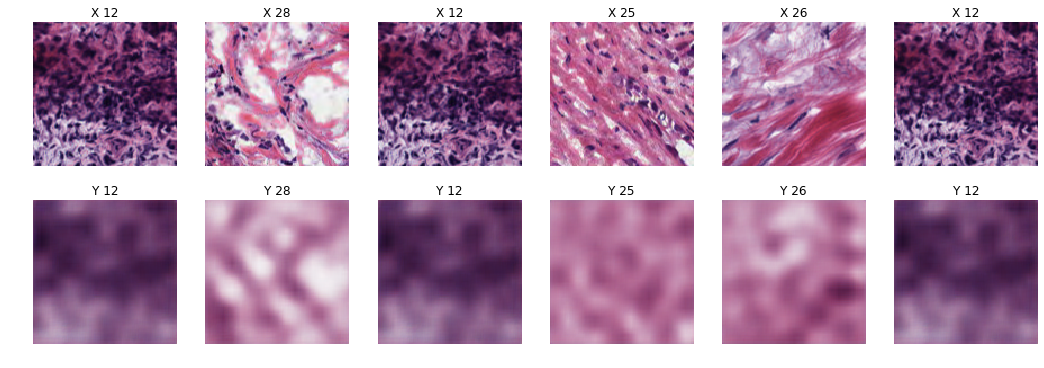

In [59]:
plot_paired_imgs(X_train, X_train_out, N=6)

In [60]:
X_test = next(test_generator)[0]
X_test_out = cae.model.predict(X_test)

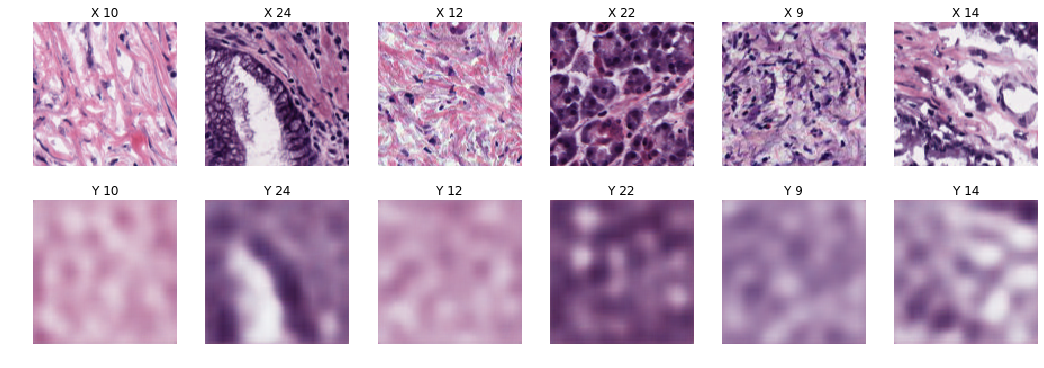

In [61]:
plot_paired_imgs(X_test, X_test_out, N=6)

### Entrenamiento Múltiple

Si se desea entrenar varios modelos y dejar la máquina ejecutándose durante un largo periodo de tiempo sin supervisión se recomienda utilizar este paso. En una lista de diccionarios se definen las arquitecturas de cada uno de los modelos a entrenar y se da un _id_. El proceso automáticamente entrenará cada uno de las redes y lo guardará en la ruta indicada con el nombre *model_id*. Además, se puede ver en *TensorBoard* el proceso de entrenamiento.

Se ha añadido el *callback EarlyStopping* para reducir el periodo de entrenamiento. Las redes se entrenan durante un total de 30 epochs o hasta que haya 3 epochs seguidas sin mejora en la validación (parémtro _patience_).

In [62]:
models = [{'id': 1, 'filters': [8,16,32], 'latent_features': 256},
          {'id': 2, 'filters': [8,16,32], 'latent_features': 512},
          {'id': 3, 'filters': [8,16,32], 'latent_features': 1024},
          {'id': 4, 'filters': [8,16,32,64], 'latent_features': 512}]

In [ ]:
EPOCHS = 30

for model in models:
    
    print()
    
    cae = CAE(input_shape=(image_size, image_size, 3), 
              latent_features=model['latent_features'], 
              filters=model['filters'],
              path=os.path.join(models_path, 'model_{}'.format(model['id'])))
    
    
    tb = TensorBoard(log_dir='../logs/model_{}'.format(model['id']), 
                 write_grads=True, write_images=True, histogram_freq=0)
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
    
    cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb, es],
                        workers = 12)
    
    cae.save()

## CAE Tumor vs CAE Normal

En este apartado se entrenan dos CAE por separado, uno con datos de _slides_ tumorales y otro con datos de _slides_ normales. La idea es repetir el proceso mostrado en el ejemplo 2 de MNIST, es decir, predecir el tipo de _slide_ a la que pertenece un _patch_ a partir del error de reconstrucción con dada uno de los CAEs entrenados.

Una limitación importante y que afectará a los resultados es que el conjunto tumoral tendrá un porcentaje alto de _patches_ sanos porque las muestras estás etiquetadas a nivel _slide_.

**Balanceo de datos**

Para evitar que un modelo tenga mejor _performance_ que otro debido a la cantidad de muestras se samplea conjunto de muestras tumorales para tener el mismo número que no tumorales.

In [53]:
training_patches_tumor_df = training_patches_tumor_df.sample(n=len(training_patches_normal_df), 
                                                             random_state=conf['seed'])

test_patches_tumor_df = training_patches_tumor_df.sample(n=len(test_patches_normal_df), 
                                                         random_state=conf['seed'])

In [54]:
len(training_patches_tumor_df)

6208

In [55]:
len(training_patches_normal_df)

6208

__Lectores de imágenes__

De nuevo se crean los objetos generadores de imágenes para no cargar todas en memoria.

In [56]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

Tumor

In [57]:
train_tumor_generator = train_datagen.flow_from_dataframe(training_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                          target_size=(image_size, image_size), color_mode='rgb', class_mode='input',
                                                          subset='training', seed=conf['seed'])

validation_tumor_generator = train_datagen.flow_from_dataframe(training_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                               target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                               subset='validation', seed=conf['seed'])

Found 4967 images.
Found 1241 images.


In [59]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_tumor_generator = test_datagen.flow_from_dataframe(test_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                        target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                        seed=conf['seed'])

Found 1251 images.


Normal

In [60]:
train_normal_generator = train_datagen.flow_from_dataframe(training_patches_normal_df, directory=patches_path, x_col='filename', 
                                                           target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                           subset='training', seed=conf['seed'])

validation_normal_generator = train_datagen.flow_from_dataframe(training_patches_normal_df, directory=patches_path, x_col='filename', 
                                                                target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                                subset='validation', seed=conf['seed'])

Found 4967 images.
Found 1241 images.


In [62]:
test_normal_generator = test_datagen.flow_from_dataframe(test_patches_normal_df, directory=patches_path, x_col='filename', 
                                                         target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                         seed=conf['seed'])

Found 1251 images.


__Entrenamiento de los modelos__

En este apartado se hamn explorado varias opciones de aquitectura y todas con resultados similares. Por un lado se probaron una arquitecturas con una capa de variables latentes pequeña, 50 o 100 neuronas con la idea de que, como se mostraba en el dataset de MNIST, esa capa final fuera muy específica al conjunto de entradas. Como los resultados no fueron se hizo justo lo contrario, entrenar un modelo muy complejo con 4 capas convolucionales y sin capa de variables latentes. Al no tener la capa de variables latentes no se reduce al dimensionalidad y por tanto la reconstrucción tiene un error muy bajo. Si hubiera diferencias importante entre el conjunto de imágenes tumorales y las normales la reconstrucción no sería tan buena en el conjunto que el modelo "no ha visto".

In [72]:
EPOCHS = 20

In [86]:
cae_tumor = CAE(input_shape=(image_size, image_size, 3), latent_features=None, filters=[8,16,32,64],
                path=os.path.join(models_path, 'model_tumor'), load=True)

In [87]:
cae_normal = CAE(input_shape=(image_size, image_size, 3), latent_features=None, filters=[8,16,32,64],
                 path=os.path.join(models_path, 'model_normal'), load=True)

In [ ]:
tb = TensorBoard(log_dir='../logs/model_tumor', 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_tumor.model.fit_generator(generator = train_tumor_generator, 
                              validation_data = validation_tumor_generator,
                              steps_per_epoch = len(train_tumor_generator),
                              validation_steps = len(validation_tumor_generator),
                              epochs = EPOCHS, 
                              callbacks = [tb])

cae_tumor.save()

In [ ]:
tb = TensorBoard(log_dir='../logs/model_normal', 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_normal.model.fit_generator(generator = train_normal_generator, 
                              validation_data = validation_normal_generator,
                              steps_per_epoch = len(train_normal_generator),
                              validation_steps = len(validation_normal_generator),
                              epochs = EPOCHS, 
                              callbacks = [tb])

cae_normal.save()

__Evaluación de errores de reconstrucción__

Los errores de reconstrucción son siempre mejor con el modelo entrenado con datos tumorales, es más, el modelo de datos normales tiene mejor rendimiento con los datos tumorales. Esto hace pensar que el ruido que introducen todas las imágenes erróneamente etiquedadas hace que ambos modelos aprendan a reconstruir este tipo de imágenes sin problema. Otra de las posibles causas es el número de muestras, aunque 1000 muestras de test es un número razonable, todas las de tejido normal están generadas a partir de 8 slides únicamente, cualquier pequeña diferencia respecto al resto que tenga una de estas 8 slides puede afectar a los resultados.

Tumor data - Tumor model

In [111]:
cae_tumor.model.evaluate_generator(test_tumor_generator, steps=len(test_tumor_generator))

0.005975753457905601

Tumor data - Normal Model

In [113]:
cae_normal.model.evaluate_generator(test_tumor_generator, steps=len(test_tumor_generator))

0.006375152966101393

Normal data - Tumor model

In [112]:
cae_tumor.model.evaluate_generator(test_normal_generator, steps=len(test_normal_generator))

0.007920297858812254

Normal data - Normal Model

In [114]:
cae_normal.model.evaluate_generator(test_normal_generator, steps=len(test_normal_generator))

0.008245299941376983

__Ejemplos__

En los siguientes ejemplos no se puede apreciar a simple vista diferencias entre los resultados con unos modelos y con otros.

In [93]:
X_test_tumor = next(test_tumor_generator)[0]
X_test_normal = next(test_normal_generator)[0]

Tumor data - Tumor model

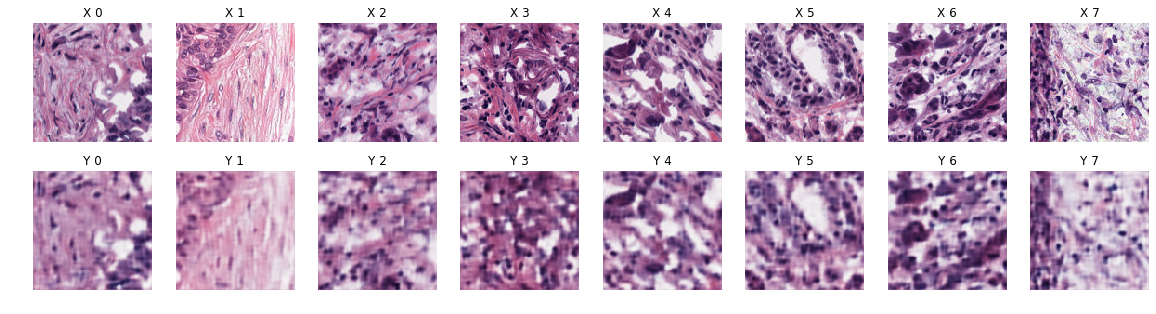

In [106]:
X_test_tumor_cae_tumor = cae_tumor.model.predict(X_test_tumor)
plot_paired_imgs(X_test_tumor, X_test_tumor_cae_tumor, N=8, shuffle=False, size=2.5)

Tumor data - Normal model

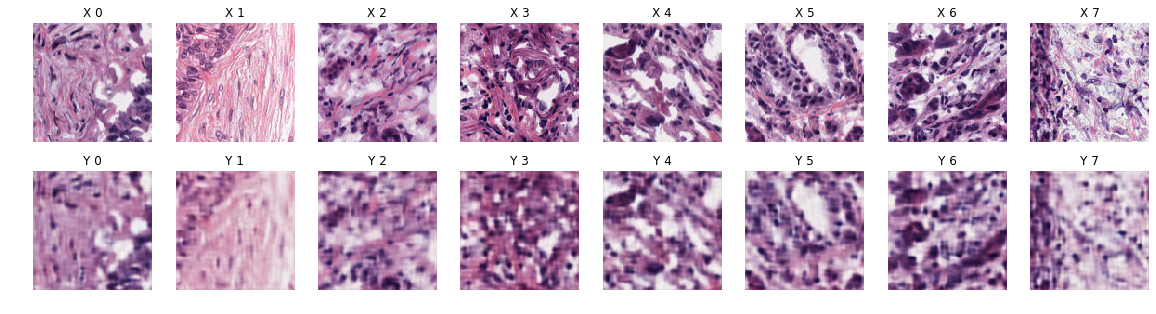

In [107]:
X_test_tumor_cae_normal = cae_normal.model.predict(X_test_tumor)
plot_paired_imgs(X_test_tumor, X_test_tumor_cae_normal, N=8, shuffle=False, size=2.5)

Normal data - Tumor Model

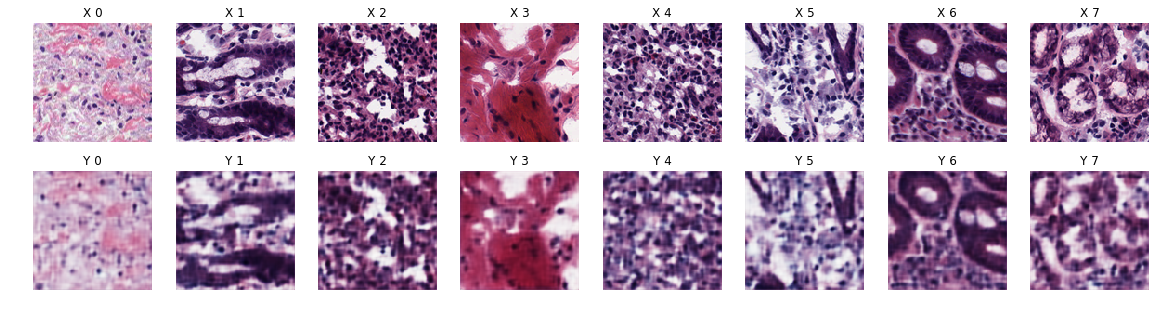

In [109]:
X_test_normal_cae_tumor = cae_tumor.model.predict(X_test_normal)
plot_paired_imgs(X_test_normal, X_test_normal_cae_tumor, N=8, shuffle=False, size=2.5)

Normal data - Normal model

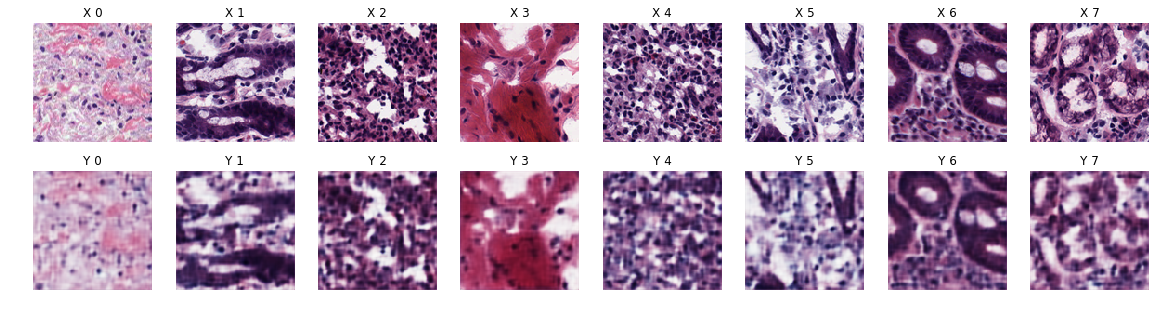

In [110]:
X_test_normal_cae_normal = cae_tumor.model.predict(X_test_normal)
plot_paired_imgs(X_test_normal, X_test_normal_cae_normal, N=8, shuffle=False, size=2.5)